In [7]:
import math
import sys 

sys.path.append('..')

from brian2 import *
from DynapSE import DynapSE
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Spike_G import SpikeGen

# Display plots inside Jupyter cell
%matplotlib inline
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

Theoretically, this behavior is a fast depression from PV and a slow depression from SST

Neurons:

1. Excitory neurons make up about 80% of the total neuronal population.
2. Inhibitory neurons make up about 20% of the total neuronal population. 
3. PV neurons (58% inhibitory) are fast-spiking.
4. SST neurons (42% inhibitory)  are low-threshold spiking. 
5. PC neurons (excitatory) are regular spiking.

Synaptic Connectivities: 

6. PC are highly interconnected (25% to 36% of connectivity probabilities). 
7. SST and PV cells connect to at least half, or even all excitatory cells of the local circuit (> 50% ).
8. Strong inhibition between SST and PC. 
9. PV has recurrent connections. 
10. PC has has Shortterm depression to PV and Short-Term Facilitation to SST

Thalamacortical connections: 

11. Strong connections to PV. (Short-term depression)
12. weak connections to SST. (Short-term facilitation)
13. Constant strength to PC. 

In [9]:
freq_list=[10]*Hz
inp_duration=5


input_monitors=[]
PC_monitors_t=[]
SST_monitors_t=[]
PV_monitors_t=[]
PC_monitors_i=[]
SST_monitors_i=[]
PV_monitors_i=[]

for freq in freq_list:   
    # to start a new build to run multiple full simulations
    device.reinit()
    device.activate()
    # need to reset the defaultclock after activate
    defaultclock.dt = 20 * us

    # Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
    network = Network()
    chip = DynapSE(network)

    # ///////////////////////////// Populations ////////////////////////////////////////////////
    # number neurons
    n = 30
    exc = round(n * 0.8)
    inh = round(n * 0.2)
    n_PC = exc 
    n_SST = round(inh * 0.42)
    n_PV = round(inh * 0.58)
    #print("neurons:"+str(n_PC)+str(n_SST)+str(n_PV))

    # define the populations of neurons
    PC = chip.get_neurons(n_PC, 'Core_1') 
    PV = chip.get_neurons(n_PV, 'Core_2')
    SST = chip.get_neurons(n_SST, 'Core_3')

    
    # ///////////////////////////// Freqiiecy Input to PC ////////////////////////////////////////////////
    spikegen = SpikeGen('regular',0,1,1,freq,1,'SpikeGenerator')

    # ///////////////////////////// CONNECTIONS ////////////////////////////////////////////////

    # Synapses, Thalamacortical Connections
    syn_inpPC = chip.add_connection(spikegen, PC, synapse_type='AMPA')
    chip.connect(syn_inpPC,True)
    syn_inpPV = chip.add_connection(spikegen, PV, synapse_type='AMPA_STD')
    chip.connect(syn_inpPV,True)
    syn_inpSST = chip.add_connection(spikegen, SST, synapse_type='AMPA')
    chip.connect(syn_inpSST,True)



    # Synapses, Local Connections
    syn_PC = chip.add_connection(PC, PC, synapse_type='AMPA')
    syn_PC.connect(p=0.30)
    syn_PV = chip.add_connection(PV, PV, synapse_type='GABA_B')
    chip.connect(syn_PV,True)

    syn_SSTPC = chip.add_connection(SST, PC, synapse_type='GABA_B')
    syn_SSTPC.connect(p=0.8)
    syn_PVPC = chip.add_connection(PV, PC, synapse_type='GABA_B')
    syn_PVPC.connect(p=0.8)

    syn_PCSST = chip.add_connection(PV, SST, synapse_type='AMPA')
    chip.connect(syn_PCSST,True)
    syn_PCPV = chip.add_connection(PC, PV, synapse_type='AMPA_STD')
    chip.connect(syn_PCPV,True)

    syn_PVSST = chip.add_connection(PV, SST, synapse_type='GABA_B')
    chip.connect(syn_PVSST,True)
    syn_SSTPV = chip.add_connection(SST, PV, synapse_type='GABA_B')
    chip.connect(syn_SSTPV,True)

    
    irregularity_key=1#if irregularity key is 1, we have irregular neuron behavior

    #Synapses, irregularity
    if irregularity_key == 1:
        irregularity_synapses_PC=[]
        irregularity_synapses_PV=[]
        irregularity_synapses_SST=[]
        irregularity_spikegen_PC=[]
        irregularity_spikegen_PV=[]
        irregularity_spikegen_SST=[]

        for i in range(n_PC):
                irregularity_spikegen_PC.append(SpikeGen('poisson',0,inp_duration,inp_duration,10,1,'SpikeGenerator_PC'+str(i)))
                irregularity_synapses_PC.append(chip.add_connection(irregularity_spikegen_PC[i],PC[i:i+1],synapse_type='AMPA'))
                irregularity_synapses_PC[i].connect(True)
                irregularity_synapses_PC[i].weight=20
        for i in range(n_PV):
                irregularity_spikegen_PV.append(SpikeGen('poisson',0,inp_duration,inp_duration,10,1,'SpikeGenerator_PV'+str(i)))
                irregularity_synapses_PV.append(chip.add_connection(irregularity_spikegen_PV[i],PV[i:i+1],synapse_type='AMPA'))
                irregularity_synapses_PV[i].connect(True)
                irregularity_synapses_PV[i].weight=20
        for i in range(n_SST):
                irregularity_spikegen_SST.append(SpikeGen('poisson',0,inp_duration,inp_duration,10,1,'SpikeGenerator_SST'+str(i)))
                irregularity_synapses_SST.append(chip.add_connection(irregularity_spikegen_SST[i],SST[i:i+1],synapse_type='AMPA'))
                irregularity_synapses_SST[i].connect(True)
                irregularity_synapses_SST[i].weight=20

                        

    # set Thalamacortical weights
    syn_inpPC.weight = 1
    syn_inpPV.weight = 1
    syn_inpSST.weight = 1

    # set Local connection weights
    syn_PC.weight = 5
    syn_PV.weight = 20
    syn_SSTPC.weight = 60
    syn_PVPC.weight = 100
    syn_PCSST.weight = 30
    syn_PCPV.weight = 400
    syn_PVSST.weight = 20
    syn_SSTPV.weight = 30
    

    
    # NEURON CONDITIONS

    PC_conf =  {
        "Isoma_dpi_tau" :  2.5* pA,
        "Isoma_th"  : 5 * nA,  
        "alpha_soma": 1,
                

        "Isoma_ahp_tau": 30 * pA,             
        "Isoma_ahp_w" : 2000 * pA,
        "alpha_ahp"  : 4,  
                

        "soma_refP": 1 * ms,
        "Isoma_const": 150 *pA}


    PV_conf = {
        "Isoma_dpi_tau" :  7.5* pA,
        "Isoma_th"  : 3 * nA,  
        "alpha_soma": 1,
        

        "Isoma_ahp_tau": 11 * pA,             
        "Isoma_ahp_w" : 0 * pA,
        "alpha_ahp"  : 1,  
        

        "soma_refP": 1 * ms,
        "Isoma_const": 150 *pA,
        }

    SST_conf = {
        "Isoma_dpi_tau" :  3.5* pA,  
        "alpha_soma": .35,
        "Isoma_th"  : 1* nA,  

        "Isoma_ahp_tau": 30 * pA,             
        "Isoma_ahp_w" : 500 * pA,
        

        "soma_refP": 2 * ms,
        "Isoma_const": 150 *pA,
           }

    
    # SYNAPSE CONDITIONS 

    #only PV should have short term depression
    syn_PV_conf = {
            "Iampa_std_tau": 2 * pA,
            "Va" :100*mV,
            "Vw" :0*mV,
            "tau_pulse" : 1 *ms,
            "Idischarge_w":20*pA} 


    syn_PC_conf = {"Iampa_tau": 1 * pA,
                        "Iampa_w0":50*pA}

    syn_SST_conf = {"Iampa_tau": 2 * pA,
                  "Iampa_w0":25*pA}

    

    mon_SST_Imem = StateMonitor(SST,'Isoma_mem',record=True)
    mon_PV_Imem=StateMonitor(PV,'Isoma_mem',record=True)
    mon_PC_Imem = StateMonitor(PC,'Isoma_mem',record=True)
    mon_SST_Input_1 = StateMonitor(syn_inpSST,'Iampa',record=[0])
    mon_SST_Input_2 = StateMonitor(syn_inpSST,'Iampa',record=[1])
    network.add([mon_SST_Imem,mon_PC_Imem,mon_SST_Input_1,mon_SST_Input_2,mon_PV_Imem])

    # set the params
    chip.set_bias(PC_conf, 'Core_1')
    chip.set_bias(PV_conf, 'Core_2')
    chip.set_bias(SST_conf, 'Core_3')
    chip.set_bias(syn_PC_conf,'Core_1')
    chip.set_bias(syn_PV_conf,'Core_2')
    chip.set_bias(syn_SST_conf,'Core_3')
    
    # Monitors
    mon_neuron_input  = SpikeMonitor(spikegen, name='mon_neuron_input')
    SST_output = SpikeMonitor(SST, name='SST_output')
    PV_output = SpikeMonitor(PV, name='PV_output')
    PC_output = SpikeMonitor(PC, name='PC_output')

    network.add([spikegen,PC,SST,PV,syn_inpPC,syn_inpPV,syn_inpSST,syn_PC,syn_PV,syn_SSTPC,syn_PVPC,syn_PCSST,syn_PCPV,syn_PVSST,syn_SSTPV,SST_output,mon_neuron_input,PV_output,PC_output])
    network.add([irregularity_synapses_SST,irregularity_synapses_PC,irregularity_synapses_PV,irregularity_spikegen_PC,irregularity_spikegen_SST,irregularity_spikegen_PV])
    # Simulation
    network.run(inp_duration * 1000 * ms)
    
    input_monitors.append(mon_neuron_input.t/ms)
    PC_monitors_t.append(PC_output.t/ms)
    PV_monitors_t.append(PV_output.t/ms)
    SST_monitors_t.append(SST_output.t/ms)
    PC_monitors_i.append(np.array(PC_output.i))
    PV_monitors_i.append(np.array(PV_output.i))
    SST_monitors_i.append(np.array(SST_output.i))

    print('PC soma tau= ', PC[0:1].tau_soma)
    print('PV soma tau= ', PV[0:1].tau_soma)
    print('SST soma tau= ',SST[0:1].tau_soma)


   




24 neurons are allocated from Core_1.
3 neurons are allocated from Core_2.
3 neurons are allocated from Core_3.
New bias values are loaded to Core_1.
New bias values are loaded to Core_2.
New bias values are loaded to Core_3.
New bias values are loaded to Core_1.
New bias values are loaded to Core_2.
New bias values are loaded to Core_3.
PC soma tau=  <Core_1_subgroup_1.tau_soma: array([28.36879433]) * msecond>
PV soma tau=  <Core_2_subgroup.tau_soma: array([70.92198582]) * msecond>
SST soma tau=  <Core_3_subgroup.tau_soma: array([20.26342452]) * msecond>


ValueError: x and y must have same first dimension, but have shapes (250000,) and (1, 250000)

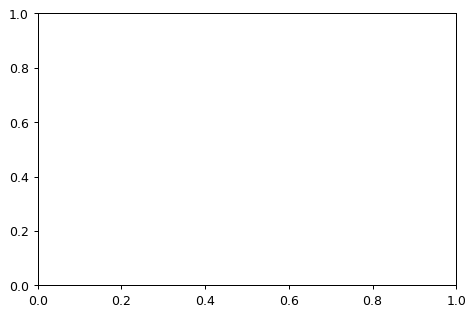

In [14]:
plot(mon_SST_Input_1.t,mon_SST_Input_2.Iampa)

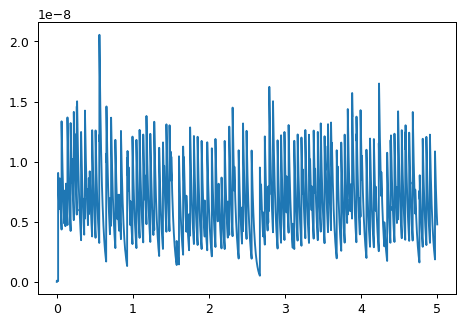

In [19]:
plot(mon_SST_Input_2.t,mon_SST_Input_2.Iampa[0])

In [30]:
print(mon_SST_Input_2.Iampa[0][0:10])

[  1.         101.         100.943036   100.88610413 100.82920436
 100.77233669 100.7155011  100.65869755 100.60192605 100.54518656] pA


In [31]:
print(mon_SST_Input_2.Iampa[0][0:10])

[  1.         101.         100.943036   100.88610413 100.82920436
 100.77233669 100.7155011  100.65869755 100.60192605 100.54518656] pA


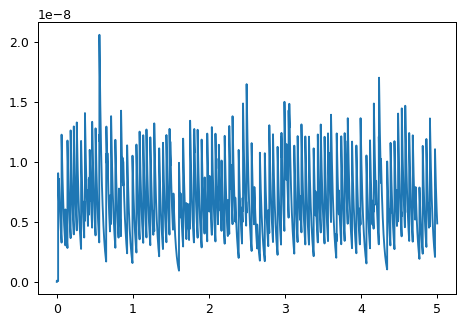

In [12]:
plot(mon_SST_Input_1.t,mon_SST_Input_1.Iampa[0])

SST output firing rate=  6.4 Hz
PC output firing rate=  1. Hz
PV output firingi rate=  19.6 Hz
SST output firing rate=  4.2 Hz
PC output firing rate=  0.8 Hz
PV output firingi rate=  20. Hz
SST output firing rate=  9.8 Hz
PC output firing rate=  1.2 Hz
PV output firingi rate=  23. Hz


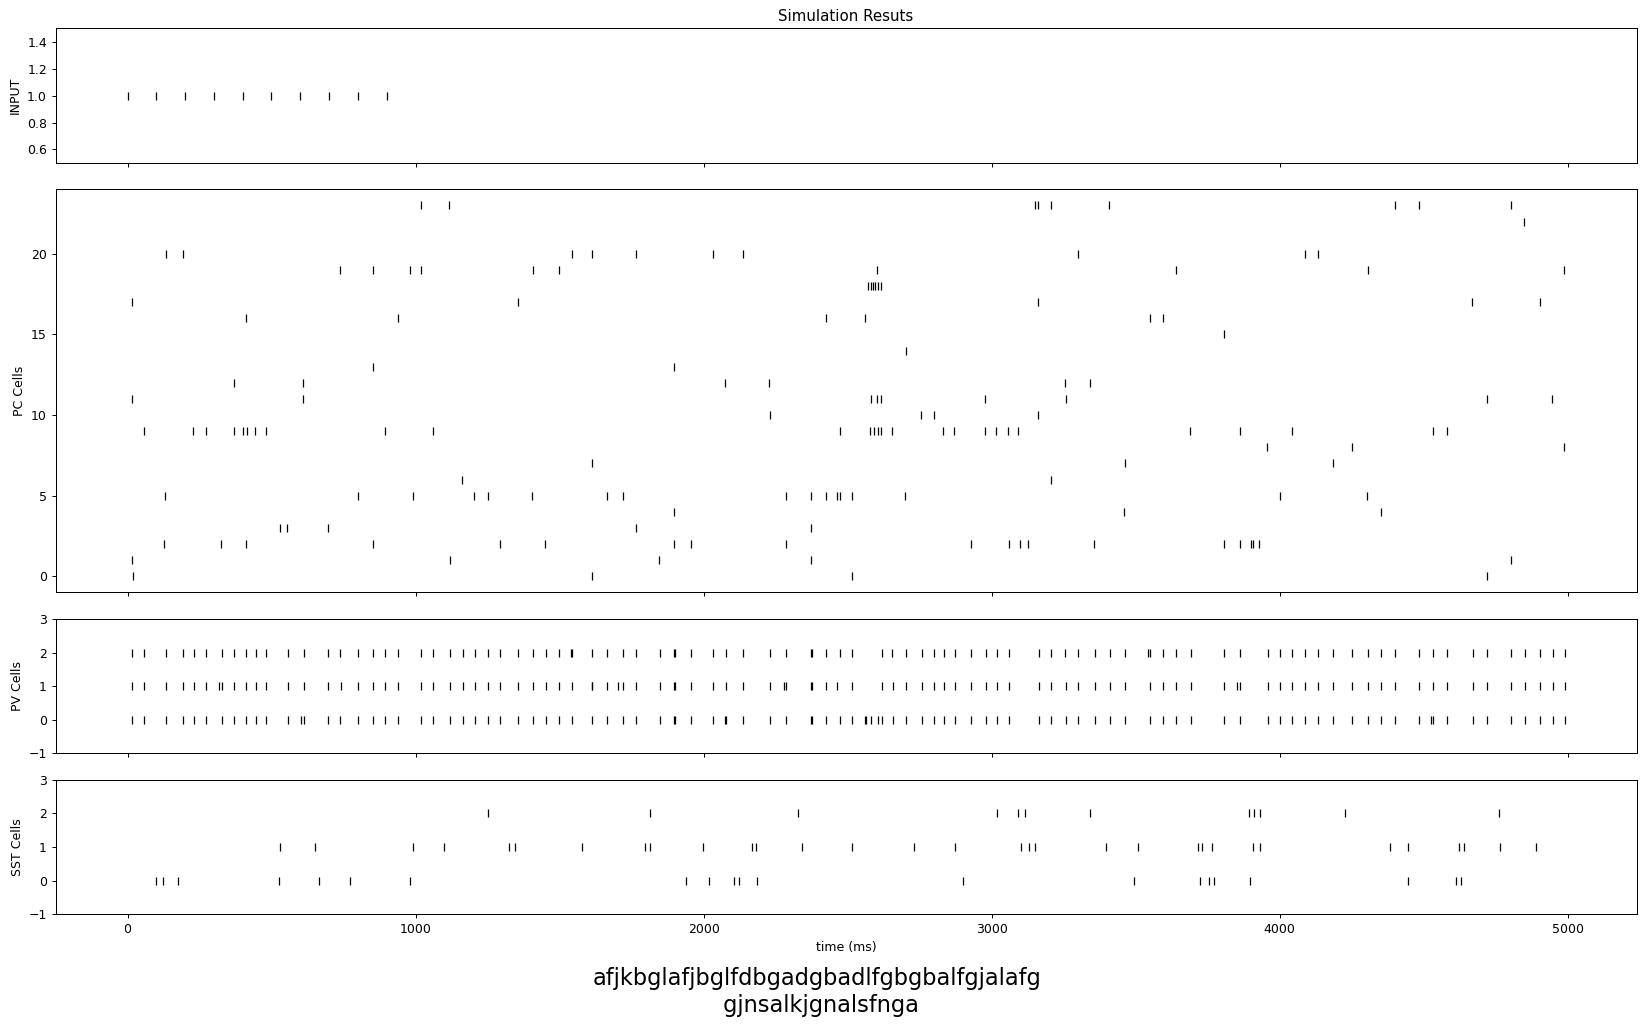

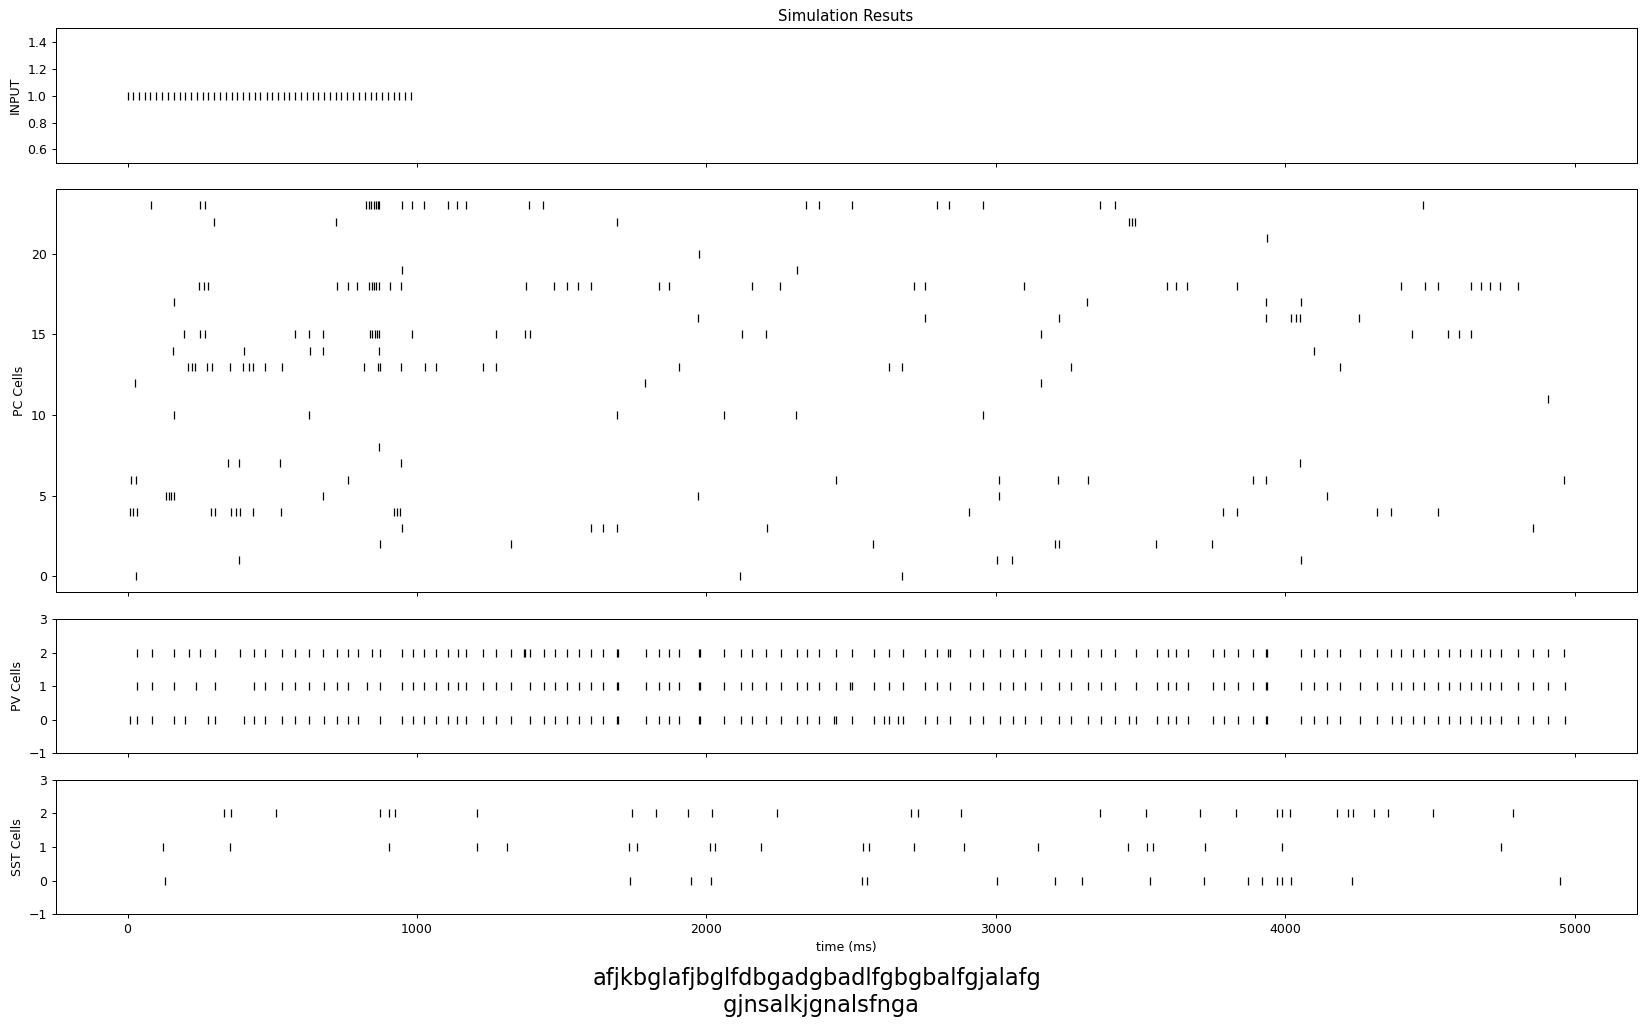

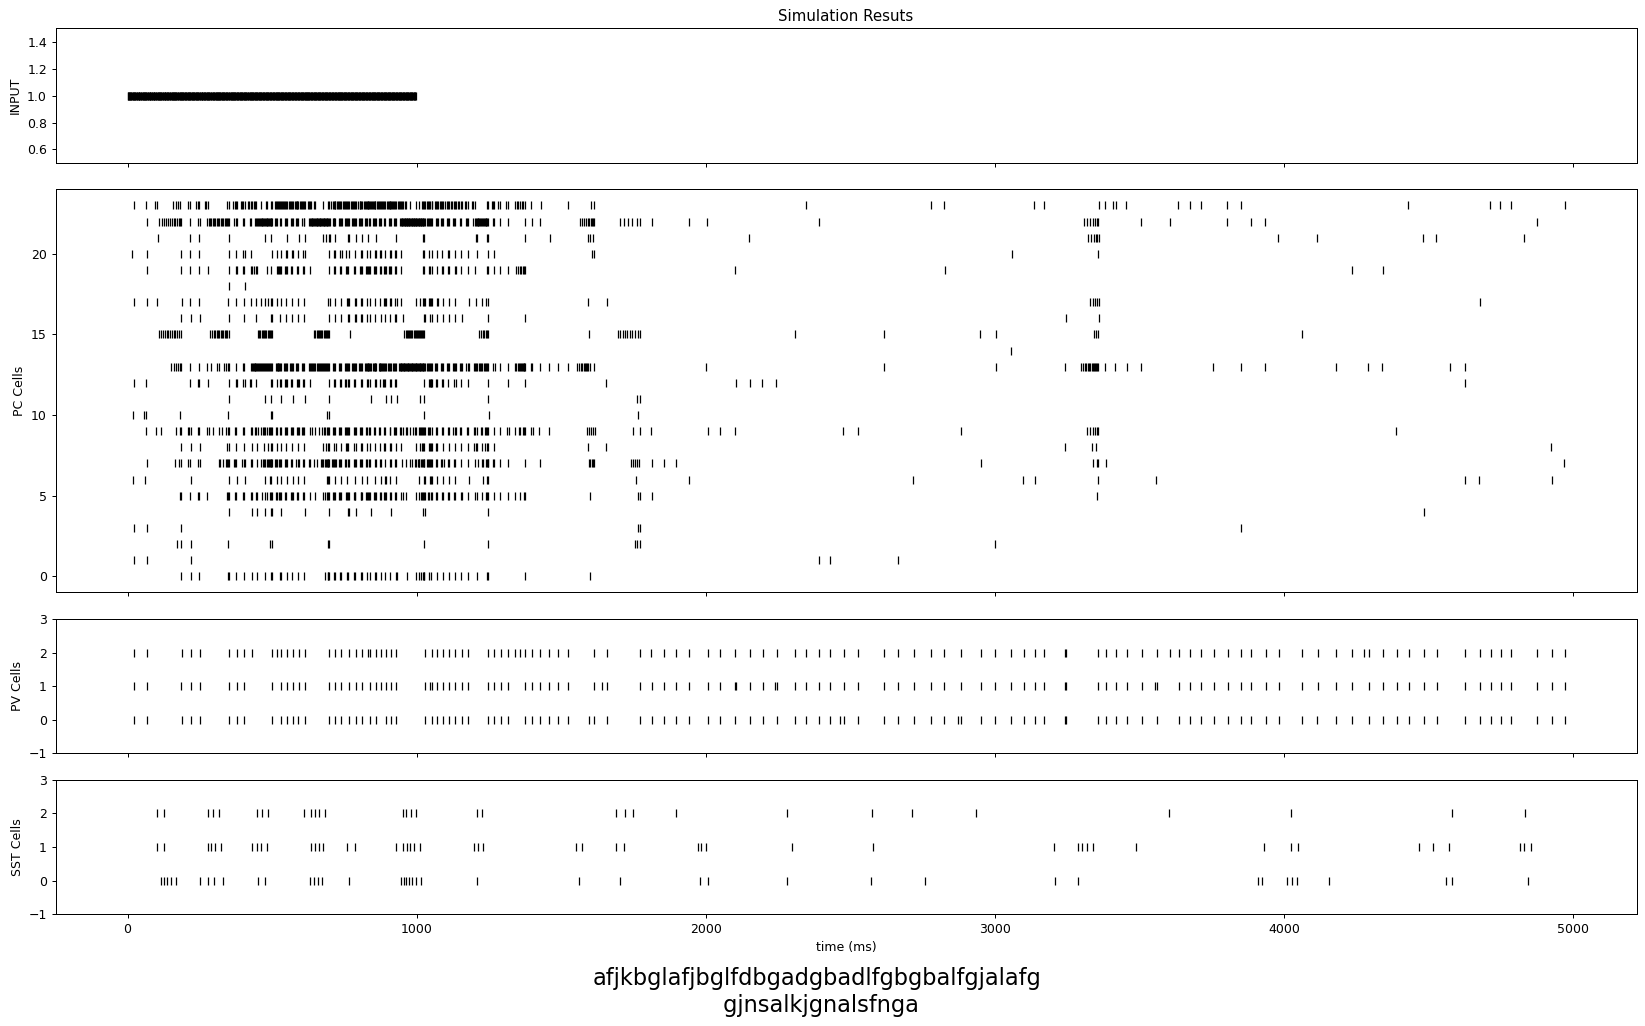

In [ ]:
for i in range(len(freq_list)): 

    print('SST output firing rate= ', len(SST_monitors_t[i][SST_monitors_i[i]==1])/ (inp_duration* 1000 * ms))
    print('PC output firing rate= ', len(PC_monitors_t[i][PC_monitors_i[i]==1])/ (inp_duration* 1000 * ms))
    print('PV output firingi rate= ', len(PV_monitors_t[i][PV_monitors_i[i]==1])/ (inp_duration* 1000 * ms))
    

    f, (a0, a1,a2,a3) = plt.subplots(4, 1,sharex=True, gridspec_kw={'height_ratios': [1, 3,1,1]}) 
    spike_placeholder = np.zeros(1000)
    spike_placeholder[np.array(input_monitors[i], dtype=int)]=1
    a0.plot(spike_placeholder,'k|')
    a0.set_ylim(0.5, 1.5)
    a0.set_title('Simulation Resuts')
    a0.set_ylabel('INPUT')

    a1.plot(PC_monitors_t[i],PC_monitors_i[i],'k|')
    a1.set_ylim(-1, n_PC)
    
    a1.set_ylabel('PC Cells')
    a2.plot(PV_monitors_t[i],PV_monitors_i[i],'k|')
    a2.set_ylim(-1, n_PV)
    
    a2.set_ylabel('PV Cells')
    a3.plot(SST_monitors_t[i],SST_monitors_i[i],'k|')
    a3.set_ylim(-1, n_SST)
    a3.set_ylabel('SST Cells')
    a3.set_xlabel('time (ms)')

    f.set_size_inches(18.5, 11.5)
    f.tight_layout(rect=[0,2,5,4])
    f.savefig('grid_figure.png')

    plt.suptitle('afjkbglafjbglfdbgadgbadlfgbgbalfgjalafg\n gjnsalkjgnalsfnga', y=0.00,fontsize=18)

    #plt.figtext(0.5, 0.01, "one text and next text", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.tight_layout()
    


In [ ]:


for k in range(3):
    i_val=PC_monitors_i[k]
    t_val=PC_monitors_t[k]
    cv_list=[]
    for i in range(n_PC+1):   
        isi=np.diff(t_val[i_val==i])
        cv=np.var(isi)/(np.average(isi)**2)
        cv_list.append(cv)  

    cv_list=np.asanyarray(cv_list)
    cv_list = cv_list[~numpy.isnan(cv_list)]
    PC_average=mean(cv_list)
    
    print("PC Squared Coefficient of variation freq "+str(k)+": "+str(PC_average))

for k in range(3):
    i_val=PV_monitors_i[k]
    t_val=PV_monitors_t[k]
    cv_list=[]
    for i in range(n_PC+1):   
        isi=np.diff(t_val[i_val==i])
        cv=np.var(isi)/(np.average(isi)**2)
        cv_list.append(cv)  

    cv_list=np.asanyarray(cv_list)
    cv_list = cv_list[~numpy.isnan(cv_list)]
    PV_average=mean(cv_list)
    print("PV Squared Coefficient of variation freq "+str(k)+": "+str(PV_average))


for k in range(3):
    i_val=SST_monitors_i[k]
    t_val=SST_monitors_t[k]
    cv_list=[]
    for i in range(n_PC+1):   
        isi=np.diff(t_val[i_val==i])
        cv=np.var(isi)/(np.average(isi)**2)
        cv_list.append(cv)  
    print
    cv_list=np.asanyarray(cv_list)
    cv_list = cv_list[~numpy.isnan(cv_list)]
    SST_average=mean(cv_list)
    print("SST Squared Coefficient of variation freq "+str(k)+": "+str(SST_average))





WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
 [py.warnings]
WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
 [py.warnings]
WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_meth

PC Squared Coefficient of variation freq 0: 0.7087008538890655
PC Squared Coefficient of variation freq 1: 1.3262907027618653
PC Squared Coefficient of variation freq 2: 10.45216927195462
PV Squared Coefficient of variation freq 0: 0.1579713763318236
PV Squared Coefficient of variation freq 1: 0.150484368819792
PV Squared Coefficient of variation freq 2: 0.2968789555925364
SST Squared Coefficient of variation freq 0: 0.8271989219608974
SST Squared Coefficient of variation freq 1: 1.093820040940059
SST Squared Coefficient of variation freq 2: 1.5756925924253122


In [ ]:
PC_monitors_t[i],PC_monitors_i[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
PC_monitors_t[0][PC_monitors_i[0]==i]
var(np.diff(PC_monitors_t))/average(np.diff(PC_monitors_t))

WARNING    /home/hector/miniconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
 [py.warnings]


ValueError: operands could not be broadcast together with shapes (211,) (158,) 